<hr style="border:2px solid black">
Internet Buzz and the Movie Box Office
<hr style="border:2px solid black">

### Import libraries and load data

In [1]:
# import libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eigh
import sklearn.preprocessing as prep
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn import linear_model
import seaborn as sns

In [2]:
# format the primary settings
os.chdir(r'C:\Users\neelk\Documents\UTD\HW1')
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

In [3]:
# loading data
df = pd.read_csv(r'data\boxOffice.csv')

In [4]:
# take a brief overview of the dataset
df.head() #show the first five rows

,box,G,PG,PG13,budget,starpowr,sequel,action,comedy,animated,horror,addict,cmngsoon,fandango,cntwait3
0,19167085,0,0,0,28.0,19.83,0,0,1,0,0,7860.50,10,144,0.49
1,63106589,0,1,0,150.0,32.69,1,0,0,1,0,5737.00,59,468,0.79
2,5401605,0,0,0,37.4,15.69,0,0,1,0,0,850.00,24,198,0.36
3,67528882,0,0,1,200.0,23.62,1,1,0,0,0,15326.00,93,1778,0.76
4,26223128,0,1,0,150.0,19.02,0,0,0,1,0,4574.25,30,1109,0.53


In [5]:
df.info() # basic information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   box       62 non-null     int64  
 1   G         62 non-null     int64  
 2   PG        62 non-null     int64  
 3   PG13      62 non-null     int64  
 4   budget    62 non-null     float64
 5   starpowr  62 non-null     float64
 6   sequel    62 non-null     int64  
 7   action    62 non-null     int64  
 8   comedy    62 non-null     int64  
 9   animated  62 non-null     int64  
 10  horror    62 non-null     int64  
 11  addict    62 non-null     float64
 12  cmngsoon  62 non-null     int64  
 13  fandango  62 non-null     int64  
 14  cntwait3  62 non-null     float64
dtypes: float64(4), int64(11)
memory usage: 7.4 KB


### 1.1 Histograms of the continuous variables (box, budget, starpowr)

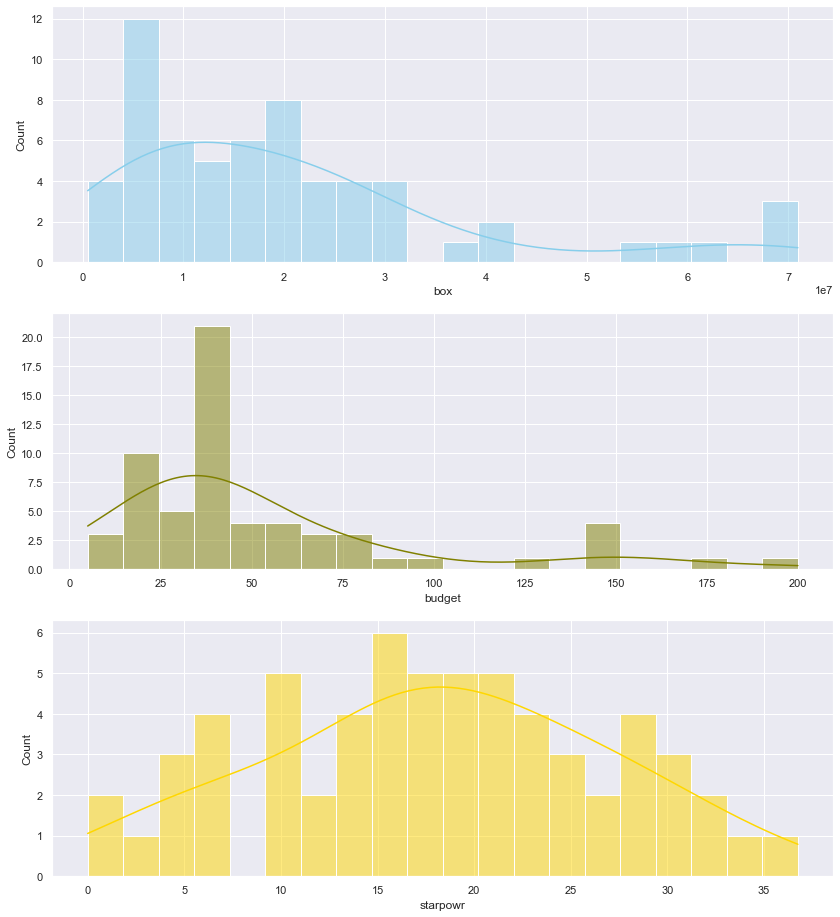

In [6]:
# Plot histograms

# set a grey background
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, figsize=(14, 16))

sns.histplot(data=df, x="box", kde=True, color="skyblue", ax=axs[0], bins=20)
sns.histplot(data=df, x="budget", kde=True, color="olive", ax=axs[1], bins=20)
sns.histplot(data=df, x="starpowr", kde=True, color="gold", ax=axs[2], bins=20)

plt.show()

### 1.2 Evaluate skewness

In [7]:
# calculate the skewness and kurtosis for three continuous variables
df[['box','budget','starpowr']].agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
box,1.474056,1.763617
budget,1.794689,2.756299
starpowr,-0.067433,-0.547506


__As the above output and histograms for the three continuous variables show, the variables of "box" and "budget" are highly skewed to the right, while "starpowr" is fairly symmetrical. So we will perform log-transformation for "box" and "budget".__

### 1.3 Log transform two skewed variables and evaluate the skewness again

In [8]:
# log tranform two skewed variables
df['log_box']=np.log(df['box'])
df['log_budget']=np.log(df['budget'])

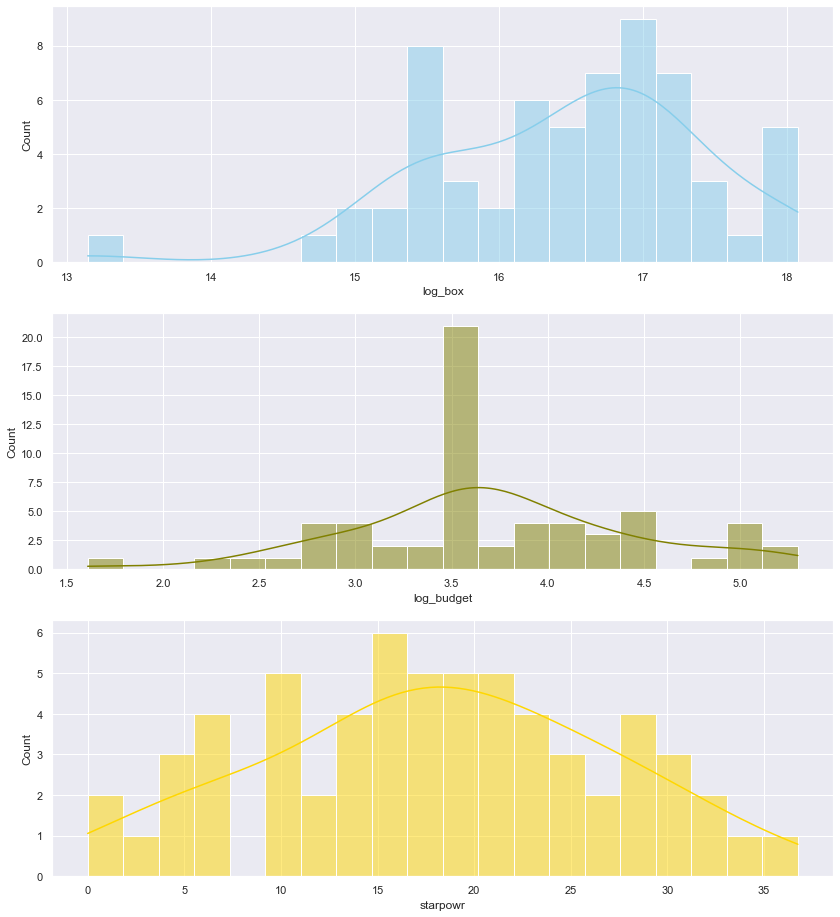

In [9]:
# Plot histograms of the continuous variables with log transformation

# set a grey background
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, figsize=(14, 16))

sns.histplot(data=df, x="log_box", kde=True, color="skyblue", ax=axs[0], bins=20)
sns.histplot(data=df, x="log_budget", kde=True, color="olive", ax=axs[1], bins=20)
sns.histplot(data=df, x="starpowr", kde=True, color="gold", ax=axs[2], bins=20)

plt.show()

### 2.1 Specify the dependent and independent variables for the regression model

In [10]:
# specify the dependent variable
y = df['log_box']
y

0     16.768705
1     17.960336
2     15.502207
3     18.028066
4     17.082152
        ...    
57    17.898476
58    15.488719
59    16.951212
60    18.077493
61    15.559836
Name: log_box, Length: 62, dtype: float64

In [11]:
#set up the independent variables
X=df.copy()

# drop the dependent variable as well as "buzz" and unlogged variables
X = X.drop(['log_box','box','budget','addict', 'cmngsoon','fandango','cntwait3'], axis = 1)

# create a copy to run the initial (pre-PCA) regression)
X1 = X.copy()

#add new constant column for the intercept
X1['const'] = 1.0
X1

,G,PG,PG13,starpowr,sequel,action,comedy,animated,horror,log_budget,const
0,0,0,0,19.83,0,0,1,0,0,3.332205,1.0
1,0,1,0,32.69,1,0,0,1,0,5.010635,1.0
2,0,0,0,15.69,0,0,1,0,0,3.621671,1.0
3,0,0,1,23.62,1,1,0,0,0,5.298317,1.0
4,0,1,0,19.02,0,0,0,1,0,5.010635,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57,0,1,0,34.86,0,0,0,1,0,5.164786,1.0
58,0,0,1,4.25,0,1,0,0,0,3.091042,1.0
59,0,0,1,5.96,0,0,0,0,1,2.815409,1.0
60,0,0,1,16.62,1,1,0,0,0,4.442651,1.0


### 2.2 Run a linear regression

In [12]:
# fit the variables into the linear regression model
linregr = sm.OLS(y,X1).fit()

# review the result summary
print(linregr.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     2.656
Date:                Sun, 11 Sep 2022   Prob (F-statistic):             0.0109
Time:                        22:52:59   Log-Likelihood:                -70.832
No. Observations:                  62   AIC:                             163.7
Df Residuals:                      51   BIC:                             187.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.2524      0.692      0.365      0.7

__As the result shows, the R squared is 0.342 and adjusted R squared 0.214. Variables significant at 10% level are “sequel”, “horror”, “log_budget” and “const”.__

### 3.1  Drop the insignificant variables at 10% level

In [13]:
X2 = X1.copy()
X2 = X2.drop(['G', 'PG','PG13','starpowr','action','comedy','animated'], axis = 1)
X2

,sequel,horror,log_budget,const
0,0,0,3.332205,1.0
1,1,0,5.010635,1.0
2,0,0,3.621671,1.0
3,1,0,5.298317,1.0
4,0,0,5.010635,1.0
...,...,...,...,...
57,0,0,5.164786,1.0
58,0,0,3.091042,1.0
59,0,1,2.815409,1.0
60,1,0,4.442651,1.0


### 3.2 Rerun the linear model and compare the result

In [14]:
#rerun the linear model
linregr2 = sm.OLS(y, X2).fit()

# review the new output
print(linregr2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     7.929
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           0.000162
Time:                        22:52:59   Log-Likelihood:                -73.175
No. Observations:                  62   AIC:                             154.4
Df Residuals:                      58   BIC:                             162.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sequel         0.4994      0.298      1.676      0.0

__We ran a linear regression only with the significant variables, the R squared is 0.291 and adjusted R squared 0.254. "sequel", "horror", "log_budget" and "const" are still significant at 10% level.__

### 4.1 Plot histogram of the four "buzz" variables

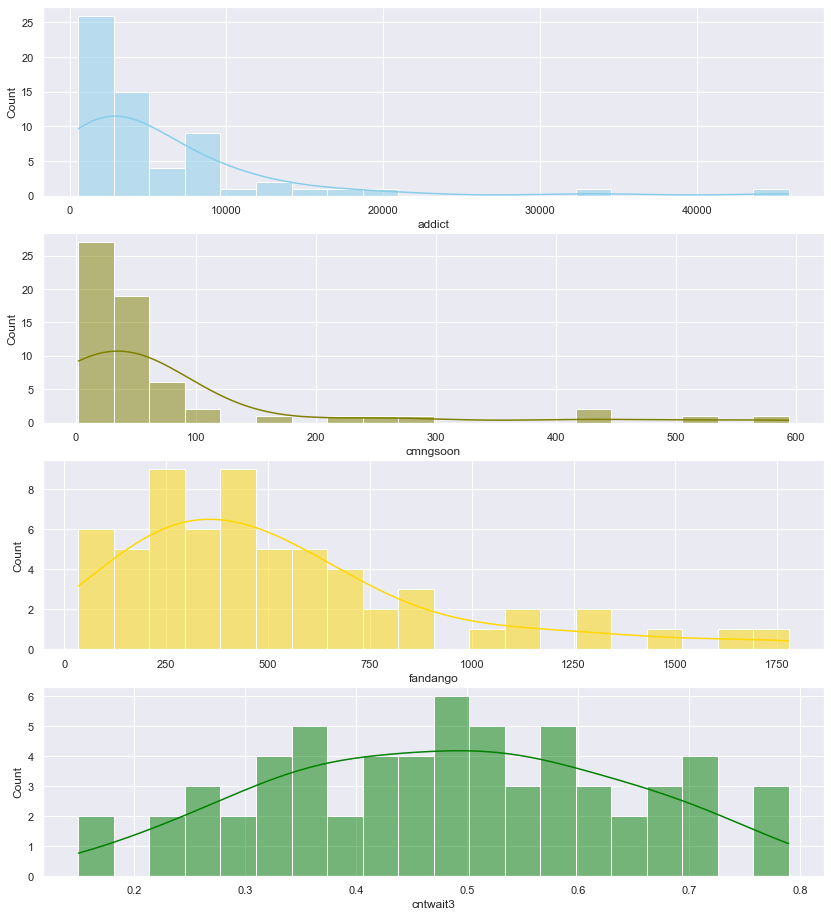

In [15]:
# Plot histograms

# set a grey background
#sns.set(style="darkgrid")
fig, axs = plt.subplots(4, figsize=(14, 16))

sns.histplot(data=df, x="addict", kde=True, color="skyblue", ax=axs[0], bins=20)
sns.histplot(data=df, x="cmngsoon", kde=True, color="olive", ax=axs[1], bins=20)
sns.histplot(data=df, x="fandango", kde=True, color="gold", ax=axs[2], bins=20)
sns.histplot(data=df, x="cntwait3", kde=True, color="green", ax=axs[3], bins=20)

plt.show()

### 4.2 Evaluate skewness

In [16]:
# calculate the skewness and kurtosis for three continuous variables
df[['addict','cmngsoon','fandango','cntwait3']].agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
addict,3.317154,13.529323
cmngsoon,2.852279,7.828820
fandango,1.403302,1.919731
cntwait3,-0.028592,-0.737009


__As the above output and histograms for the "buzz" variables show, the variables of 'addict','cmngsoon' and 'fandango' are highly skewed, while "cntwait3" is fairly symmetrical. So we will perform log-transformation for 'addict','cmngsoon' and 'fandango', and keep 'cntwait3' as it is.__

### 4.3 Log-transform the skewed variables and re-generate the histograms

In [17]:
# log tranform two skewed variables
df['log_addict']=np.log(df['addict'])
df['log_cmngsoon']=np.log(df['cmngsoon'])
df['log_fandango']=np.log(df['fandango'])

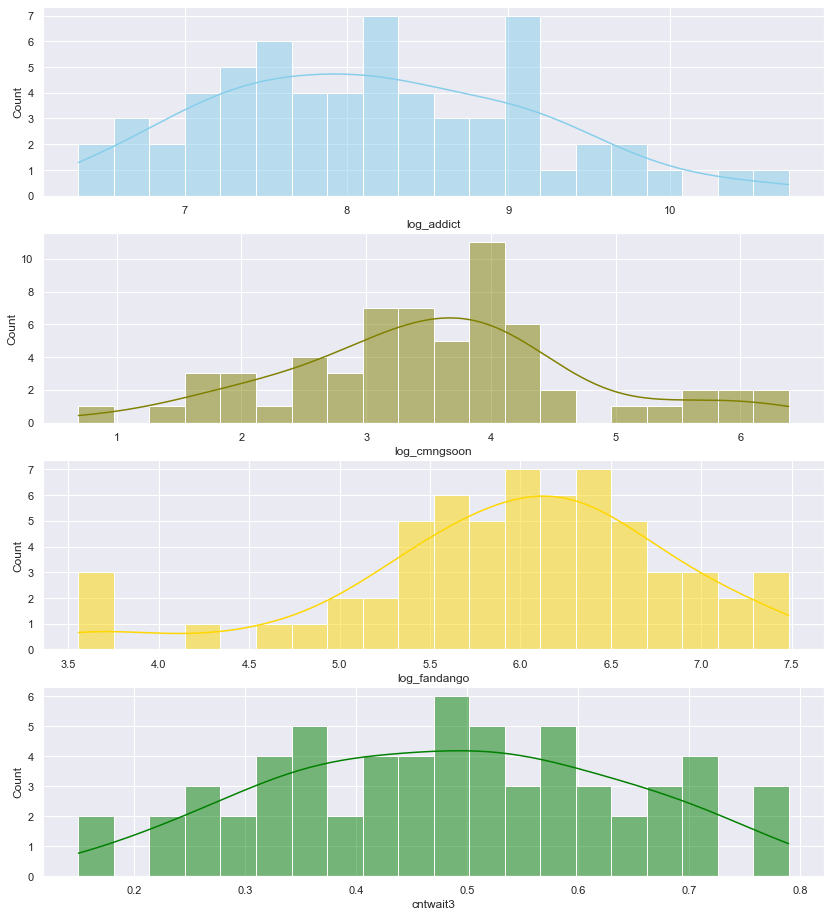

In [18]:
# Evaluate the variables again after log-transformation

# set a grey background
sns.set(style="darkgrid")
fig, axs = plt.subplots(4, figsize=(14, 16))

sns.histplot(data=df, x="log_addict", kde=True, color="skyblue", ax=axs[0], bins=20)
sns.histplot(data=df, x="log_cmngsoon", kde=True, color="olive", ax=axs[1], bins=20)
sns.histplot(data=df, x="log_fandango", kde=True, color="gold", ax=axs[2], bins=20)
sns.histplot(data=df, x="cntwait3", kde=True, color="green", ax=axs[3], bins=20)

plt.show()

### 5.1  Specify independent variables for the regression model

In [19]:
X3 = df.copy()
X3 = X3.drop(['box','log_box','budget','addict','cmngsoon','fandango'], axis = 1)
X3['const'] = 1.0
X3

,G,PG,PG13,starpowr,sequel,action,comedy,animated,horror,cntwait3,log_budget,log_addict,log_cmngsoon,log_fandango,const
0,0,0,0,19.83,0,0,1,0,0,0.49,3.332205,8.969605,2.302585,4.969813,1.0
1,0,1,0,32.69,1,0,0,1,0,0.79,5.010635,8.654692,4.077537,6.148468,1.0
2,0,0,0,15.69,0,0,1,0,0,0.36,3.621671,6.745236,3.178054,5.288267,1.0
3,0,0,1,23.62,1,1,0,0,0,0.76,5.298317,9.637306,4.532599,7.483244,1.0
4,0,1,0,19.02,0,0,0,1,0,0.53,5.010635,8.428198,3.401197,7.011214,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,1,0,34.86,0,0,0,1,0,0.70,5.164786,9.114435,4.219508,6.472346,1.0
58,0,0,1,4.25,0,1,0,0,0,0.62,3.091042,8.066521,4.543295,3.663562,1.0
59,0,0,1,5.96,0,0,0,0,1,0.53,2.815409,9.774745,4.060443,4.804021,1.0
60,0,0,1,16.62,1,1,0,0,0,0.71,4.442651,9.269521,6.386879,6.744059,1.0


### 5.2 Run a linear regression

In [20]:
linreg = sm.OLS(y,X3).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     5.576
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           3.77e-06
Time:                        22:53:02   Log-Likelihood:                -53.492
No. Observations:                  62   AIC:                             137.0
Df Residuals:                      47   BIC:                             168.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
G                0.6375      0.600      1.063   

__We ran a linear regression with the all the independent variables. The R squared is 0.624 and adjusted R squared 0.512.  Variables significant at 10% level are "PG", "action", "animated", "cntwait3", "log_addict" and "const".__

### 6.1 Drop the insignificant variables

In [21]:
X4 = X3.drop(['G','PG13','starpowr','sequel','comedy','horror','log_budget','log_cmngsoon','log_fandango'], axis = 1)
X4

,PG,action,animated,cntwait3,log_addict,const
0,0,0,0,0.49,8.969605,1.0
1,1,0,1,0.79,8.654692,1.0
2,0,0,0,0.36,6.745236,1.0
3,0,1,0,0.76,9.637306,1.0
4,1,0,1,0.53,8.428198,1.0
...,...,...,...,...,...,...
57,1,0,1,0.70,9.114435,1.0
58,0,1,0,0.62,8.066521,1.0
59,0,0,0,0.53,9.774745,1.0
60,0,1,0,0.71,9.269521,1.0


### 6.2 Rerun the linear regression

In [22]:
linreg = sm.OLS(y,X4).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     14.15
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           6.06e-09
Time:                        22:53:02   Log-Likelihood:                -58.512
No. Observations:                  62   AIC:                             129.0
Df Residuals:                      56   BIC:                             141.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PG             0.3464      0.228      1.519      0.1

__We ran a linear regression with only the significant variables, the R squared is 0.558 and adjusted R squared improved to 0.519. Variables significant at 10% level are "action", "animated", "cntwait3", "log_addict" and "const".__

__We prefer the model with the traditional variables and buzz variables that are significant. It has the highest adjusted R squared and with less variables.__

### 8.1 Get the four "buzz" variables with log-transformation

In [23]:
X5 = X3.copy()
X5 = X3.drop(['G','PG','PG13','starpowr','sequel','action','comedy','animated','horror','log_budget','const'], axis = 1)
X5

,cntwait3,log_addict,log_cmngsoon,log_fandango
0,0.49,8.969605,2.302585,4.969813
1,0.79,8.654692,4.077537,6.148468
2,0.36,6.745236,3.178054,5.288267
3,0.76,9.637306,4.532599,7.483244
4,0.53,8.428198,3.401197,7.011214
...,...,...,...,...
57,0.70,9.114435,4.219508,6.472346
58,0.62,8.066521,4.543295,3.663562
59,0.53,9.774745,4.060443,4.804021
60,0.71,9.269521,6.386879,6.744059


### 8.2 Standardize the data

In [24]:
sc = prep.StandardScaler()
sX = pd.DataFrame(sc.fit_transform(X5), columns = X5.columns)
# StandardScaler uses the population variance/standard deviation
# calculate the sample standard deviation of the result and scale by dividing with it 
sc.scale_ = np.std(sX, axis=0, ddof=1).to_list()
#print(sc.scale_)
sX = sX/sc.scale_
sX

,cntwait3,log_addict,log_cmngsoon,log_fandango
0,0.048398,0.803754,-1.090305,-1.141892
1,1.963723,0.487415,0.393889,0.220592
2,-0.781576,-1.430683,-0.358249,-0.773771
3,1.772190,1.474477,0.774406,1.763547
4,0.303775,0.259896,-0.171659,1.217896
...,...,...,...,...
57,1.389125,0.949239,0.512603,0.594984
58,0.878372,-0.103418,0.783350,-2.651873
59,0.303775,1.612538,0.379595,-1.333542
60,1.452970,1.105027,2.324933,0.909074


### 8.3 Perform PCA

In [25]:
# create pca object
# not specifying the number of components results in all variables being used
pca4 = PCA()
#pass the feature set 
# fit calculates parameters; transform applies the transformation
pcs4 = pca4.fit_transform(sX)

### 8.4 Get the eigen values

In [26]:
print('\nEigen Values of Correlation Matrix')
print(pca4.explained_variance_)


Eigen Values of Correlation Matrix
[ 2.4142  0.7752  0.4521  0.3585]


### 8.5 get the proportion of variance explained by each PC

In [27]:
expldvarpca4 = pca4.explained_variance_ratio_
print(expldvarpca4)

[ 0.6036  0.1938  0.1130  0.0896]


### 8.6 cumulative sum of explained variance

In [28]:
expldvarsum4 = np.cumsum(expldvarpca4)
print('\nCumulative sum of the explained variance')
print(expldvarsum4)


Cumulative sum of the explained variance
[ 0.6036  0.7973  0.9104  1.0000]


### 8.7  plot the proportion of variance captured by each PC

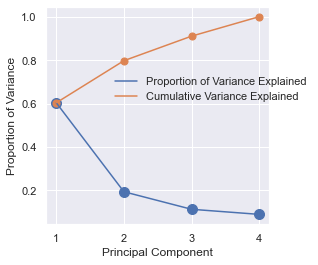

In [29]:
# plot of explained variance
plt.figure(figsize=(4, 4))
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance")
plt.xticks(np.arange(1, 5)) 
plt.plot(np.arange(1,5), expldvarpca4,label='Proportion of Variance Explained')
plt.scatter(np.arange(1,5), expldvarpca4, s = 100)
plt.scatter(np.arange(1,5), expldvarsum4, s = 50)
plt.plot(np.arange(1,5), expldvarsum4,label='Cumulative Variance Explained')
plt.legend(bbox_to_anchor=(0.29, 0.7), loc='upper left', borderaxespad=0, fancybox = True, framealpha = 0)
plt.savefig(r'ExplainedVariance-PCA.png', transparent = "true")

### 8.8 Screen Plot

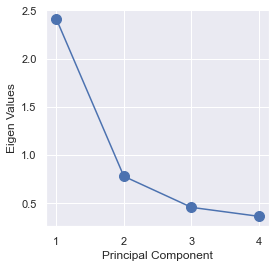

In [30]:
# scree plot (Eigen Values against sorted PCs)
plt.figure(figsize=(4, 4))
plt.xlabel("Principal Component")
plt.ylabel("Eigen Values")
plt.xticks(np.arange(1, 5)) 
plt.plot(np.arange(1,5), pca4.explained_variance_)
plt.scatter(np.arange(1,5), pca4.explained_variance_, s = 100)
plt.savefig(r'Scree-PCA.png', transparent = "true")

### 8.9 print the PCs, cumulative proportion of variance explained, and eigen values

In [31]:
# print components
print('\nPrincipal Components')
print(pca4.components_)
print('\nExplained Variance Proportion by Component')
print(expldvarpca4)
print('\nEigen Values of Correlation Matrix')
print(pca4.explained_variance_)


Principal Components
[[ 0.5436  0.5113  0.5489  0.3766]
 [ 0.1270  0.3393  0.1849 -0.9135]
 [ 0.5398 -0.7745  0.2921 -0.1535]
 [ 0.6301  0.1539 -0.7611 -0.0093]]

Explained Variance Proportion by Component
[ 0.6036  0.1938  0.1130  0.0896]

Eigen Values of Correlation Matrix
[ 2.4142  0.7752  0.4521  0.3585]


### 8.10 The transformed data

In [32]:
print(pcs4)

[[-0.5912  1.1204 -0.7396  0.9946]
 [ 1.6160  0.2861  0.7636  1.0105]
 [-1.6444  0.0559  0.7003 -0.4328]
 [ 2.8064 -0.7424 -0.2298  0.7378]
 [ 0.6624 -1.0175 -0.2744  0.3507]
 [ 4.0177 -0.1422 -0.3635 -0.2124]
 [-0.3890  0.3927 -0.1231  0.4387]
 [-0.4759 -0.4376  0.3626  1.6835]
 [ 0.7923  0.0369  0.4835 -0.0152]
 [ 1.8398 -0.0862  0.9589 -0.9974]
 [-2.8426  1.8773 -0.0275 -0.4601]
 [-3.1643 -0.5472 -0.0025 -0.2218]
 [ 2.3323  0.1453 -0.1044  0.0499]
 [-2.1141 -1.1141  0.5012  0.0748]
 [ 1.5426 -0.0808  0.0523  0.8452]
 [ 0.0288 -0.2395  0.8008  0.3262]
 [ 0.4728 -0.4215  0.5001  1.0480]
 [-0.3565  0.1692  0.9991 -0.1002]
 [ 0.1200 -0.0730  0.0498  0.3507]
 [ 1.0826  0.4547 -0.2247  0.5609]
 [ 0.0482 -0.2750  0.2043 -0.4896]
 [ 1.0581 -1.0442 -0.3098 -0.4616]
 [-1.4748 -1.2920 -0.9048 -0.0470]
 [-1.1418  2.5054 -0.0059 -0.5527]
 [-1.4534  1.2994  1.6463  0.5705]
 [ 0.0723  1.5015 -1.6197 -0.1167]
 [-3.1622 -0.5650 -0.4415 -0.1479]
 [-0.4004 -1.2401  0.1767  0.6221]
 [-1.7262 -0.8289  0

### 8.11 create a dataframe with transformed components

In [33]:
pcs4df = pd.DataFrame(pcs4, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
print(pcs4df)

         PC1       PC2       PC3       PC4
0  -0.591216  1.120419 -0.739575  0.994585
1   1.615992  0.286131  0.763648  1.010510
2  -1.644376  0.055875  0.700252 -0.432820
3   2.806445 -0.742427 -0.229837  0.737825
4   0.662450 -1.017549 -0.274396  0.350745
..       ...       ...       ...       ...
57  1.745896  0.049794  0.073061  0.625717
58 -0.144094  2.643883  1.190069 -0.034036
59  0.695724  1.874180 -0.769292  0.163062
60  2.973264  0.158961  0.468080 -0.692292
61 -0.003581  0.489791 -0.728942  0.402951

[62 rows x 4 columns]


__Using Kaiser’s rule, one PC will be chosen. Using 60% rule, one PC will be chosen.
Using 70% rule, two PCs will be chosen. Using 80% & 90%  rule, three PCs will be chosen.__

### 9.1 Specify all the independent variables (with all 4 pricipal components)

In [34]:
X6=pd.concat([X1, pcs4df],axis = 1)
X6

,G,PG,PG13,starpowr,sequel,action,comedy,animated,horror,log_budget,const,PC1,PC2,PC3,PC4
0,0,0,0,19.83,0,0,1,0,0,3.332205,1.0,-0.591216,1.120419,-0.739575,0.994585
1,0,1,0,32.69,1,0,0,1,0,5.010635,1.0,1.615992,0.286131,0.763648,1.010510
2,0,0,0,15.69,0,0,1,0,0,3.621671,1.0,-1.644376,0.055875,0.700252,-0.432820
3,0,0,1,23.62,1,1,0,0,0,5.298317,1.0,2.806445,-0.742427,-0.229837,0.737825
4,0,1,0,19.02,0,0,0,1,0,5.010635,1.0,0.662450,-1.017549,-0.274396,0.350745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,1,0,34.86,0,0,0,1,0,5.164786,1.0,1.745896,0.049794,0.073061,0.625717
58,0,0,1,4.25,0,1,0,0,0,3.091042,1.0,-0.144094,2.643883,1.190069,-0.034036
59,0,0,1,5.96,0,0,0,0,1,2.815409,1.0,0.695724,1.874180,-0.769292,0.163062
60,0,0,1,16.62,1,1,0,0,0,4.442651,1.0,2.973264,0.158961,0.468080,-0.692292


### 9.2 Run a linear regression with the above variables

In [35]:
linregr2 = sm.OLS(y, X6).fit()
#predictions = model.predict(X) 
print(linregr2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     5.576
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           3.77e-06
Time:                        22:53:03   Log-Likelihood:                -53.492
No. Observations:                  62   AIC:                             137.0
Df Residuals:                      47   BIC:                             168.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.6375      0.600      1.063      0.2

__We ran a linear regression with traditional variables and the PCAs, the R squared is 0.624 and adjusted R squared 0.512. Variables significant at 10% level are "PG", "action", "animated", "const" and "PC1". "PC1" is significant and it looks just like the model in question 5 since PCs are linear combinations of the original buzz variables.__

### 10.1 Running regression with only components with explained variance thresholds of 60%, or based on Kaiser's Rule

In [36]:
# regression with ONLY 1 components (explained variance threholds of 60% /  Kaiser's Rule)
X7 = X6.drop(['PC2', 'PC3', 'PC4'], axis = 1)
linregr3 = sm.OLS(y,X7).fit()
#predictions = model.predict(X) 
print(linregr3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     6.510
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.39e-06
Time:                        22:53:03   Log-Likelihood:                -56.278
No. Observations:                  62   AIC:                             136.6
Df Residuals:                      50   BIC:                             162.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.3844      0.553      0.695      0.4

### 10.2 Running regression with only components with explained variance thresholds of 70%

In [37]:
X8 = X6.drop(['PC3', 'PC4'], axis = 1)
linregr4 = sm.OLS(y,X8).fit()
#predictions = model.predict(X) 
print(linregr4.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     6.357
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.27e-06
Time:                        22:53:03   Log-Likelihood:                -54.729
No. Observations:                  62   AIC:                             135.5
Df Residuals:                      49   BIC:                             163.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.4933      0.549      0.898      0.3

### 10.3 Running regression with only components with explained variance thresholds of 80%/90%

In [38]:
X9 = X6.drop(['PC4'], axis = 1)
linregr5 = sm.OLS(y,X9).fit()
#predictions = model.predict(X) 
print(linregr5.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     5.752
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           3.32e-06
Time:                        22:53:03   Log-Likelihood:                -54.715
No. Observations:                  62   AIC:                             137.4
Df Residuals:                      48   BIC:                             167.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.4635      0.592      0.783      0.4

__We prefer the model with the traditional variables, PC1 and PC2, that are significant. It has the highest adjusted R squared and with less variables.__

### 11.1 Get ready with the data

In [39]:
X10 = X3.copy()
X10 = X3.drop(['G','PG','PG13','sequel','action','comedy','animated','horror','const'], axis = 1)
X10

,starpowr,cntwait3,log_budget,log_addict,log_cmngsoon,log_fandango
0,19.83,0.49,3.332205,8.969605,2.302585,4.969813
1,32.69,0.79,5.010635,8.654692,4.077537,6.148468
2,15.69,0.36,3.621671,6.745236,3.178054,5.288267
3,23.62,0.76,5.298317,9.637306,4.532599,7.483244
4,19.02,0.53,5.010635,8.428198,3.401197,7.011214
...,...,...,...,...,...,...
57,34.86,0.70,5.164786,9.114435,4.219508,6.472346
58,4.25,0.62,3.091042,8.066521,4.543295,3.663562
59,5.96,0.53,2.815409,9.774745,4.060443,4.804021
60,16.62,0.71,4.442651,9.269521,6.386879,6.744059


### 11.2 Standarize the variables

In [40]:
sc = prep.StandardScaler()
sX = pd.DataFrame(sc.fit_transform(X10), columns = X10.columns)
# StandardScaler uses the population variance/standard deviation
# calculate the sample standard deviation of the result and scale by dividing with it 
sc.scale_ = np.std(sX, axis=0, ddof=1).to_list()
#print(sc.scale_)
sX = sX/sc.scale_

### 11.3 Perform PCA and get eigen values

In [41]:
# create pca object
# not specifying the number of components results in all variables being used
pca6 = PCA()
#pass the feature set 
# fit calculates parameters; transform applies the transformation
pcs6 = pca6.fit_transform(sX)

In [42]:
print('\nEigen Values of Correlation Matrix')
print(pca6.explained_variance_)


Eigen Values of Correlation Matrix
[ 2.8382  1.4544  0.7023  0.4430  0.3405  0.2215]


### 11.4 get the proportion of variance explained by each PC

In [43]:
expldvarpca6 = pca6.explained_variance_ratio_
print(expldvarpca6)

[ 0.4730  0.2424  0.1171  0.0738  0.0567  0.0369]


### 11.5 cumulative sum of explained variance

In [44]:
expldvarsum6 = np.cumsum(expldvarpca6)
print('\nCumulative sum of the explained variance')
print(expldvarsum6)


Cumulative sum of the explained variance
[ 0.4730  0.7154  0.8325  0.9063  0.9631  1.0000]


### 11.6 print the PCs, eigen values, and cumulative proportion of variance explained

In [45]:
# print components
print('\nPrincipal Components')
print(pca6.components_)

print('\nEigen Values of Correlation Matrix')
print(pca6.explained_variance_)

print('\nExplained Variance Proportion by Component')
print(expldvarpca6)


Principal Components
[[-0.2435 -0.5172 -0.4350 -0.4005 -0.4229 -0.3805]
 [-0.6698  0.0565 -0.4078  0.4038  0.4543 -0.1118]
 [ 0.2492  0.3268  0.0703  0.1965 -0.0032 -0.8874]
 [ 0.1751 -0.2782 -0.1195  0.7908 -0.4892  0.1141]
 [-0.5309 -0.2261  0.7822  0.0791 -0.1602 -0.1523]
 [ 0.3427 -0.7028  0.1156  0.0801  0.5914 -0.1378]]

Eigen Values of Correlation Matrix
[ 2.8382  1.4544  0.7023  0.4430  0.3405  0.2215]

Explained Variance Proportion by Component
[ 0.4730  0.2424  0.1171  0.0738  0.0567  0.0369]


### 11.7 Screen Plot

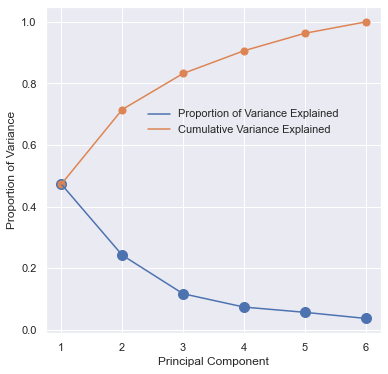

In [46]:
plt.figure(figsize=(6, 6))
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance")
plt.xticks(np.arange(1, 7)) 
plt.plot(np.arange(1,7), expldvarpca6,label='Proportion of Variance Explained')
plt.scatter(np.arange(1,7), expldvarpca6, s = 100)
plt.scatter(np.arange(1,7), expldvarsum6, s = 50)
plt.plot(np.arange(1,7), expldvarsum6,label='Cumulative Variance Explained')
plt.legend(bbox_to_anchor=(0.29, 0.7), loc='upper left', borderaxespad=0, fancybox = True, framealpha = 0)

### 11.8 create a dataframe with transformed components

In [47]:
pcs6df = pd.DataFrame(pcs6, columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'])
print(pcs6df)

         PC1       PC2       PC3       PC4       PC5       PC6
0   0.727800  0.038162  1.204158  1.123466 -0.117357 -0.448392
1  -2.637946 -1.370233  1.077239 -0.251879  0.013417 -0.366720
2   1.542932 -0.469245  0.076520 -0.857879  0.278870  0.224304
3  -3.605130 -0.458782 -0.388755  0.345631  0.690654 -0.445240
4  -1.453419 -0.892621 -0.777003  0.150703  1.127304 -0.218117
..       ...       ...       ...       ...       ...       ...
57 -2.870020 -1.454298  0.723402  0.275331  0.139703  0.201002
58  1.015619  2.049672  2.170410 -1.181606  0.225858 -0.428071
59  0.412522  2.404608  1.172586  0.762127 -0.042936 -0.285026
60 -2.919339  1.181531 -0.091520 -0.711417  0.114676  0.378143
61  0.933144  1.094761  0.242295  1.012984 -1.199726 -0.388103

[62 rows x 6 columns]


In [48]:
X11=pd.concat([X1, pcs6df],axis = 1)
X12=X11.drop(['starpowr','log_budget'],axis=1)
X12

,G,PG,PG13,sequel,action,comedy,animated,horror,const,PC1,PC2,PC3,PC4,PC5,PC6
0,0,0,0,0,0,1,0,0,1.0,0.727800,0.038162,1.204158,1.123466,-0.117357,-0.448392
1,0,1,0,1,0,0,1,0,1.0,-2.637946,-1.370233,1.077239,-0.251879,0.013417,-0.366720
2,0,0,0,0,0,1,0,0,1.0,1.542932,-0.469245,0.076520,-0.857879,0.278870,0.224304
3,0,0,1,1,1,0,0,0,1.0,-3.605130,-0.458782,-0.388755,0.345631,0.690654,-0.445240
4,0,1,0,0,0,0,1,0,1.0,-1.453419,-0.892621,-0.777003,0.150703,1.127304,-0.218117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,1,0,0,0,0,1,0,1.0,-2.870020,-1.454298,0.723402,0.275331,0.139703,0.201002
58,0,0,1,0,1,0,0,0,1.0,1.015619,2.049672,2.170410,-1.181606,0.225858,-0.428071
59,0,0,1,0,0,0,0,1,1.0,0.412522,2.404608,1.172586,0.762127,-0.042936,-0.285026
60,0,0,1,1,1,0,0,0,1.0,-2.919339,1.181531,-0.091520,-0.711417,0.114676,0.378143


In [49]:
linregr6 = sm.OLS(y, X12).fit()
print(linregr6.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     5.576
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           3.77e-06
Time:                        22:53:04   Log-Likelihood:                -53.492
No. Observations:                  62   AIC:                             137.0
Df Residuals:                      47   BIC:                             168.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.6375      0.600      1.063      0.2

In [50]:
X13 = X12.copy()
X13 = X13.drop(['PC3','PC4','PC5','PC6'], axis = 1)
linregr7 = sm.OLS(y,X13).fit()
#predictions = model.predict(X) 
print(linregr7.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     7.327
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           4.70e-07
Time:                        22:53:04   Log-Likelihood:                -56.220
No. Observations:                  62   AIC:                             134.4
Df Residuals:                      51   BIC:                             157.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.3972      0.544      0.731      0.4

In [51]:
X14 = X12.drop(['PC4','PC5','PC6'], axis = 1)
linregr8 = sm.OLS(y,X14).fit()
#predictions = model.predict(X) 
print(linregr8.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     7.198
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           3.64e-07
Time:                        22:53:04   Log-Likelihood:                -54.407
No. Observations:                  62   AIC:                             132.8
Df Residuals:                      50   BIC:                             158.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.5136      0.537      0.956      0.3

In [52]:
X15 = X12.drop(['PC5','PC6'], axis = 1)
linregr9 = sm.OLS(y,X15).fit()
#predictions = model.predict(X) 
print(linregr9.summary())

                            OLS Regression Results                            
Dep. Variable:                log_box   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     6.491
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           9.69e-07
Time:                        22:53:05   Log-Likelihood:                -54.333
No. Observations:                  62   AIC:                             134.7
Df Residuals:                      49   BIC:                             162.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.5957      0.593      1.004      0.3

__We prefer the model with PC1,PC2 and PC3. It has the highest adjusted R squared and with less variables.__ 

__Yes, ‘buzz’ variables improved the R squared  and adjusted R squared  significantly. PCA help improved the model the adjusted R squared slightly.__

# Takeaways

__It was surprising that when we used PCA on 6 variables that it needed 3 variables to have a high R squared vs when we used PCA on 4 variables it only needed 2 variables which had similar results. Based on these results though, it can be seen that "internet buzz variables" do provide additional predictive information and that if a movie wants to have a high box office, it should try to take these "internet buzz variables" into consideration.__

__Key Managerial takeaways from the above are: Addition of buzz variables can help us in building a better model for interpreting Box office revenues more accurately. PCA is a very important procedure that helps in building a model reducing dimensions. It may have different impacts on different variables. Choosing which variables to perform PCA analysis on can be very important.__